Epoch [100/2000], Loss: 0.005948604550212622
Epoch [200/2000], Loss: 0.003982902970165014
Epoch [300/2000], Loss: 0.003081744536757469
Epoch [400/2000], Loss: 0.002646396402269602
Epoch [500/2000], Loss: 0.002384301507845521
Epoch [600/2000], Loss: 0.002153153996914625
Epoch [700/2000], Loss: 0.002095170086249709
Epoch [800/2000], Loss: 0.0019603893160820007
Epoch [900/2000], Loss: 0.001870849635452032
Epoch [1000/2000], Loss: 0.0018175458535552025
Epoch [1100/2000], Loss: 0.0017041534883901477
Epoch [1200/2000], Loss: 0.0016276920214295387
Epoch [1300/2000], Loss: 0.0016201044199988246
Epoch [1400/2000], Loss: 0.0016251469496637583
Epoch [1500/2000], Loss: 0.0015068913344293833
Epoch [1600/2000], Loss: 0.0014466120628640056
Epoch [1700/2000], Loss: 0.0014213959220796824
Epoch [1800/2000], Loss: 0.0014299864415079355
Epoch [1900/2000], Loss: 0.0013533621095120907
Epoch [2000/2000], Loss: 0.0013186892028898
Average Mean Absolute Error (MAE): 26.05971983364079
Average Root Mean Squared E

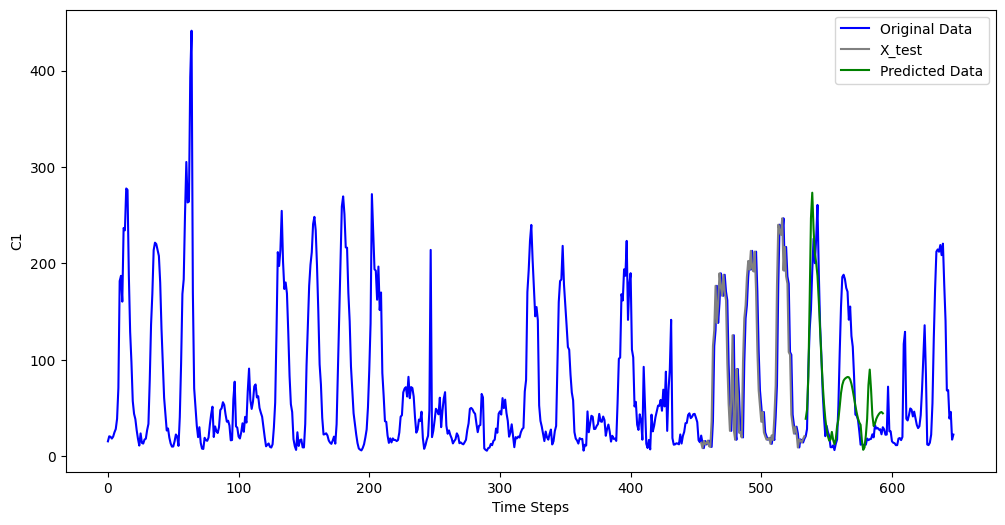

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

def create_sequences(data, day_of_week, hour, seq_length):
    sequences = []
    labels = []

    for i in range(len(data) - seq_length):
        seq = torch.cat([data[i:i+seq_length], day_of_week[i:i+seq_length], hour[i:i+seq_length]], dim=1)
        label = data[i+seq_length:i+seq_length+1]
        sequences.append(seq)
        labels.append(label)

    return torch.stack(sequences), torch.stack(labels)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


df = pd.read_csv("data/reduced/June2022_reduced.csv")
df = df[df['Grid_ID'] == 16]  # Select a single grid
df["Datetime"] = pd.to_datetime(df["Datetime"])
df.set_index("Datetime", inplace=True)

# Resample the "C1" column for each hour and calculate the mean values
df_hourly_mean = df["C1"].resample("H").mean().interpolate()    

# Create a new DataFrame with the mean values, Grid_ID, and Datetime
resampled_df = pd.DataFrame({
    "Grid_ID": df["Grid_ID"].resample("H").first(),
    "Datetime": df_hourly_mean.index,
    "C1": df_hourly_mean
})

# Add a new columns, might be useful later
resampled_df["DayOfWeek"] = resampled_df["Datetime"].dt.dayofweek
resampled_df["Hour"] = resampled_df["Datetime"].dt.hour
day_of_week_values = resampled_df["DayOfWeek"].values
day_of_week_tensor = torch.tensor(day_of_week_values, dtype=torch.float32).reshape(-1, 1)
hour_values = resampled_df["Hour"].values
hour_tensor = torch.tensor(hour_values, dtype=torch.float32).reshape(-1, 1)


target_col = 'C1'
target = resampled_df[target_col].values.reshape(-1, 1)
scaler = MinMaxScaler()
target_scaled = scaler.fit_transform(target)
target_tensor = torch.tensor(target_scaled, dtype=torch.float32)


# Define sequence length and create sequences
sequence_length = 80
sequences, labels = create_sequences(target_tensor, day_of_week_tensor, hour_tensor, sequence_length)
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42, shuffle=False)


# Initialize the model
input_size = 3 
hidden_size = 30
output_size = 1  # Predicting one value (C1)
model = LSTMModel(input_size, hidden_size, output_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 2000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)

    loss = criterion(outputs.squeeze(), y_train.squeeze()) 
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# Making predictions
model.eval()
future = 60
num_test_sequences = len(X_test) - future
test_sequences = X_test[:num_test_sequences, :, :]
predicted_sequences = []
with torch.no_grad():
    for test_seq in test_sequences:
        base_seq = test_seq.unsqueeze(0).clone()
        predicted_seq = []
        next_day = base_seq[:, -1:, 1]
        for i in range(future):
            pred = model(base_seq)
            predicted_seq.append(pred.item())

            next_hour = (base_seq[:, -1:, 2] + 1) % 24
            if(next_hour == 0):
                next_day = (base_seq[:, -1:, 1] + 1) % 7
        
            next_value = torch.cat([pred.unsqueeze(2), next_day.unsqueeze(2), next_hour.unsqueeze(2)], dim=2)  # Include hour tensor
            base_seq = torch.cat([base_seq[:, 1:, :], next_value], dim=1)
        # Inverse transform the values
        predicted_seq = np.array(predicted_seq).reshape(-1, 1)
        predicted_seq = scaler.inverse_transform(predicted_seq)
        predicted_sequences.append(predicted_seq)


y_test = scaler.inverse_transform(y_test.squeeze().reshape(-1, 1))
mae_list = []
rmse_list = []

for i in range(num_test_sequences):
    y_t = y_test[i:i+future]
    predicted_seq = predicted_sequences[i]
    mae = mean_absolute_error(y_t, predicted_seq)
    rmse = np.sqrt(mean_squared_error(y_t, predicted_seq))

    mae_list.append(mae)
    rmse_list.append(rmse)

average_mae = np.mean(mae_list)
average_rmse = np.mean(rmse_list)

print(f"Average Mean Absolute Error (MAE): {average_mae}")
print(f"Average Root Mean Squared Error (RMSE): {average_rmse}")

# Plot the results
test_start = len(target) - len(y_test)
seq_used_pred = scaler.inverse_transform(test_sequences[1, :,0].squeeze().reshape(-1, 1).clone())

plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(target)), target, label='Original Data', color='blue')
plt.plot(np.arange(test_start - len(seq_used_pred), test_start),  np.array(seq_used_pred).reshape(-1, 1), label='X_test', color='gray')
plt.plot(np.arange(test_start, test_start + future), predicted_sequences[0], label='Predicted Data', color='green')

plt.xlabel('Time Steps')
plt.ylabel(target_col)
plt.legend()
plt.show()

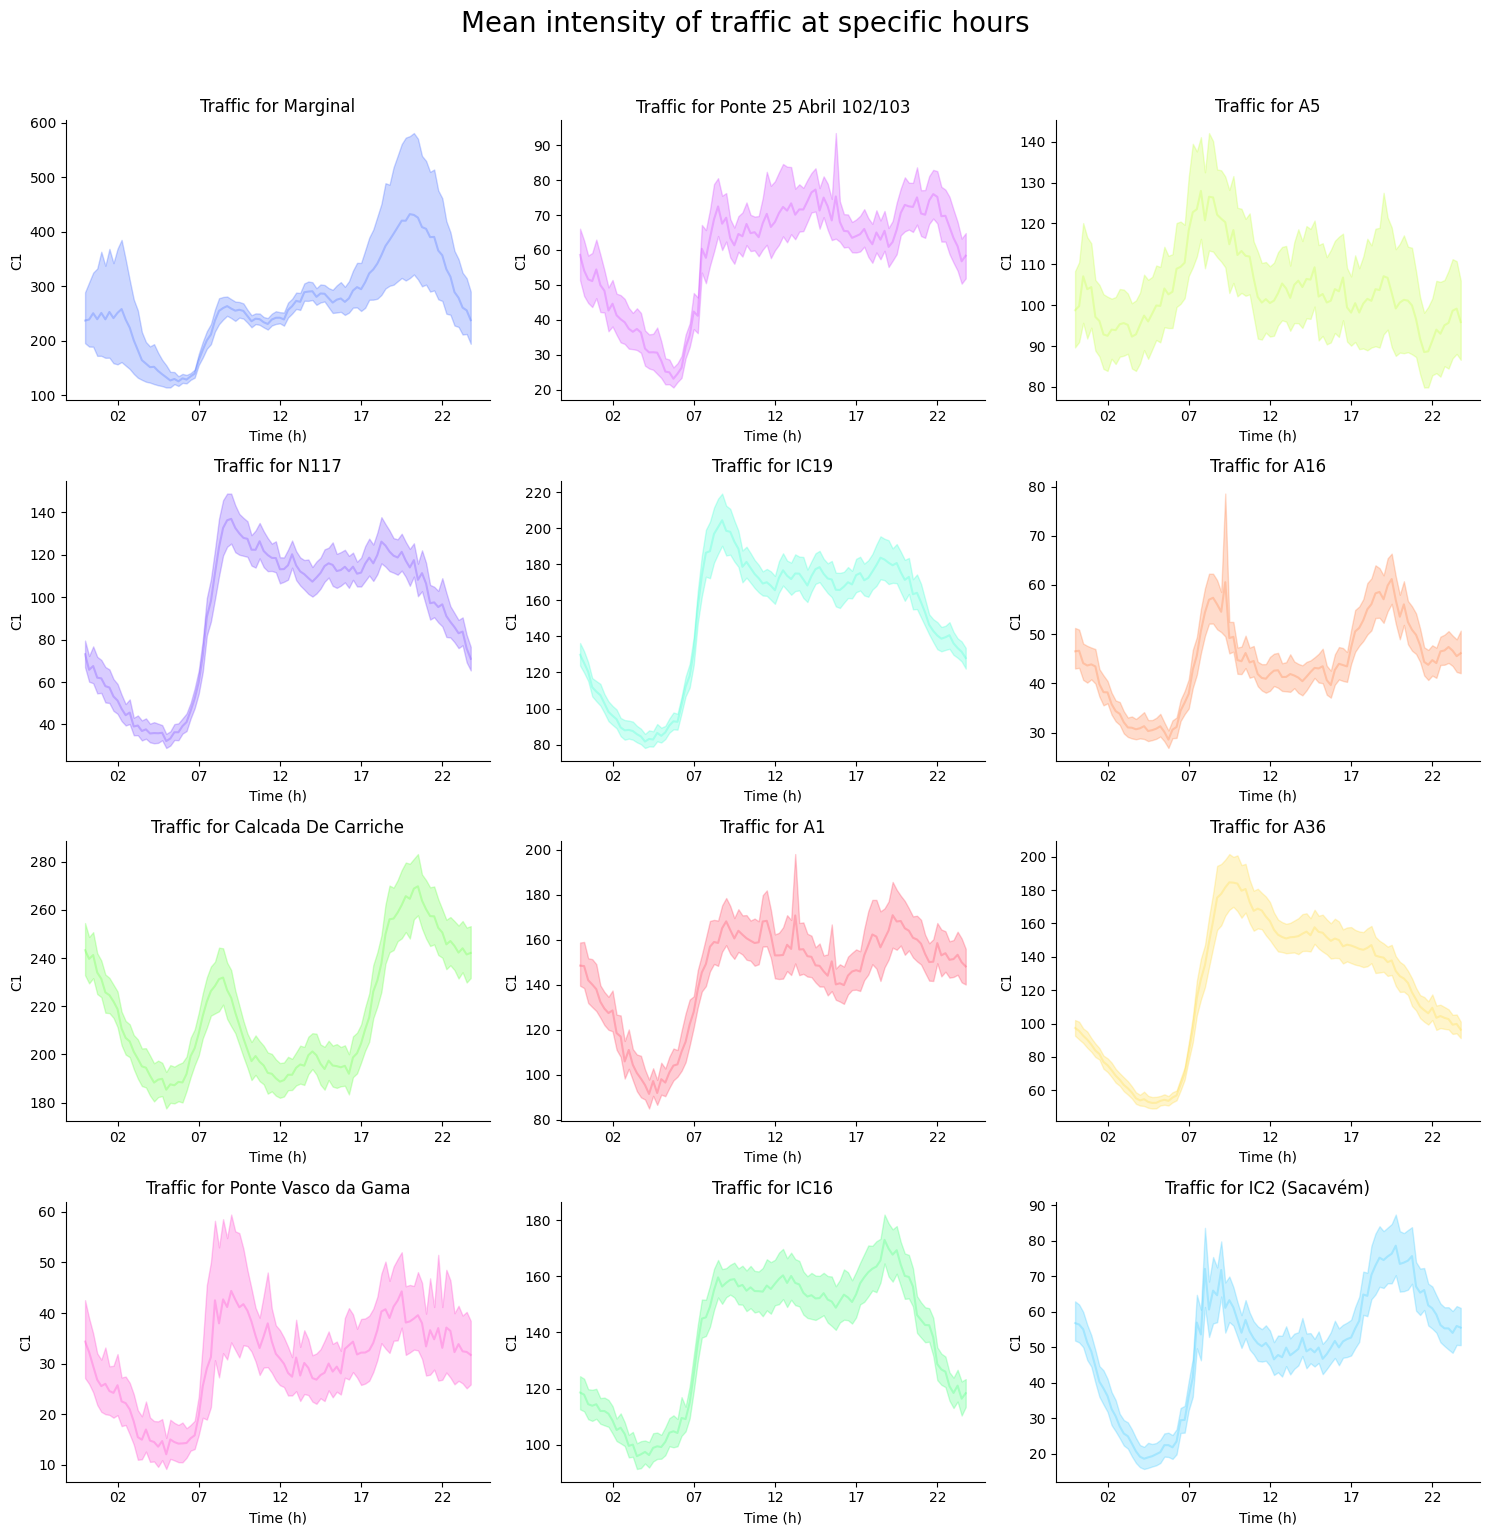

In [1]:
import cml
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib import colormaps as cm
from shapely import wkt
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates



vodafone_data = cml.VodafoneData()
main_roads_df = vodafone_data.read('data/reduced/jj') # Read the data from the folder (All Vodafone data)
vodafone_data.preprocess(main_roads_df)

columns = ['Grid_ID', 'Datetime', 'C1', 'C2', 'C11', 'E1', 'E7', 'E8', 'E9']
main_roads_df = main_roads_df[columns]

grids_df = pd.read_csv('data/wktComplete.csv', encoding='latin-1', index_col='grelha_id')
grids_df['geometry'] = grids_df.wkt.apply(wkt.loads)
grids_geo = gpd.GeoDataFrame(grids_df) 
grids_geo.sort_index(inplace=True)
grids_geo.set_crs(epsg=4326, inplace=True)
grids_geo.to_crs(epsg=3857, inplace=True)

entrance_roads_girds_id = [value for values in cml.street_names.values() for value in values]
entrance_roads_df = main_roads_df[main_roads_df.Grid_ID.isin(entrance_roads_girds_id)].copy()
entrance_roads_df.describe()


def assign_street_name(grid_id):
    for street, grid_ids in cml.street_names.items():
        if grid_id in grid_ids:
            return street
    return None

def cmap_to_dict(cmap, categories):
    return {category: cmap(i) for category, i in zip(categories, np.linspace(0, 1, len(categories)))}

grids_geo['street_name'] = grids_geo.index.map(assign_street_name)
grids_geo['street_name'] = grids_geo['street_name'].astype('category')
main_streets_grids_geo = grids_geo[grids_geo.street_name.notna()]
streets_cmap_name = 'gist_rainbow'
streets_cmap = cm.get_cmap(streets_cmap_name)
streets_cmap_dict = cmap_to_dict(streets_cmap, main_streets_grids_geo.street_name.cat.categories)

entrance_roads_df['street_name'] = entrance_roads_df.Grid_ID.map(assign_street_name)
entrance_roads_df['hour'] = entrance_roads_df.Datetime.dt.hour
entrance_roads_df['minute'] = entrance_roads_df.Datetime.dt.minute

# Get unique street names
street_names = entrance_roads_df['street_name'].unique()
num_subplots = len(street_names)
num_rows = num_subplots // 3 + (num_subplots % 3 > 0)
num_cols = min(num_subplots, 3)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
fig.suptitle('Mean intensity of traffic at specific hours', fontsize=20, y=1.02)

# Plot separately for each street name
for ax, street_name in zip(axes.flatten(), street_names):
    street_df = entrance_roads_df[entrance_roads_df['street_name'] == street_name].copy()
    street_df.set_index('Datetime', inplace=True)
    street_df = street_df.resample('15T')[['C1']].mean()
    street_df['time'] = pd.to_datetime(street_df.index.time, format='%H:%M:%S')
    sns.lineplot(x='time', y='C1', data=street_df, legend=True, c=streets_cmap_dict[street_name], ax=ax, alpha=0.2)
    ax.set_xlabel('Time (h)')
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    sns.despine()
    ax.set_title(f'Traffic for {street_name}')

plt.tight_layout()
plt.show()

Epoch [100/2000], Loss: 0.0058974321000278
Epoch [200/2000], Loss: 0.0025465821381658316
Epoch [300/2000], Loss: 0.0018541244789958
Epoch [400/2000], Loss: 0.0014681112952530384
Epoch [500/2000], Loss: 0.0011609401553869247
Epoch [600/2000], Loss: 0.0009724333649501204
Epoch [700/2000], Loss: 0.0009897507261484861
Epoch [800/2000], Loss: 0.0006545073119923472
Epoch [900/2000], Loss: 0.0007032332941889763
Epoch [1000/2000], Loss: 0.0005412962636910379
Epoch [1100/2000], Loss: 0.0004652411153074354
Epoch [1200/2000], Loss: 0.0016065348172560334
Epoch [1300/2000], Loss: 0.00039593136170879006
Epoch [1400/2000], Loss: 0.0003553384740371257
Epoch [1500/2000], Loss: 0.0003249221481382847
Epoch [1600/2000], Loss: 0.0002981999423354864
Epoch [1700/2000], Loss: 0.0008323912043124437
Epoch [1800/2000], Loss: 0.0005486369482241571
Epoch [1900/2000], Loss: 0.00045251514529809356
Epoch [2000/2000], Loss: 0.0003912866523023695
Street: Marginal
Average Mean Absolute Error (MAE): 71.22617572205188
Ave

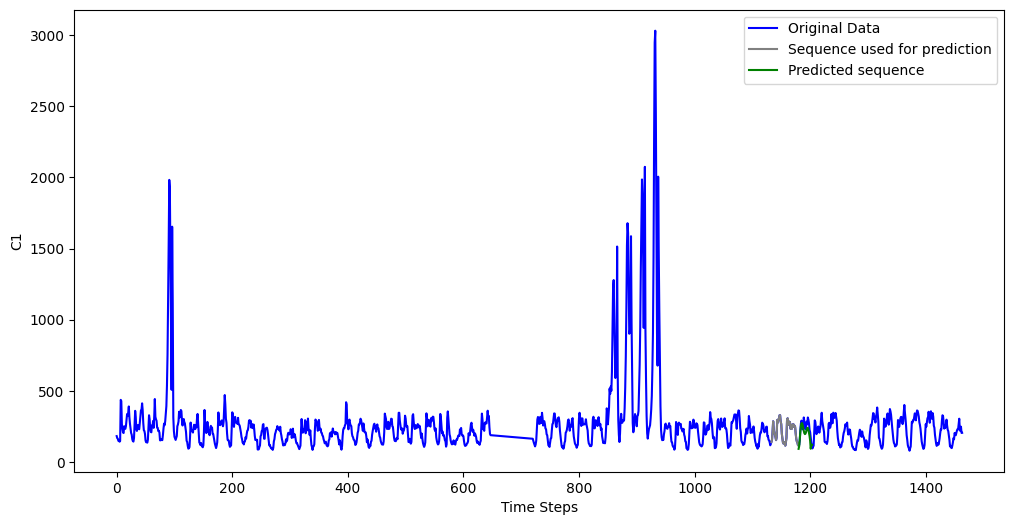

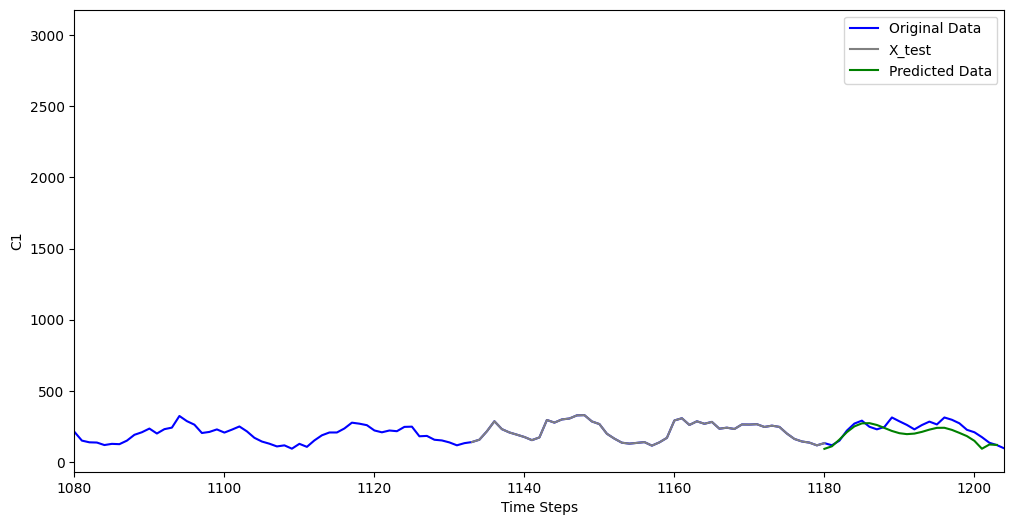

Epoch [100/2000], Loss: 0.004388229455798864
Epoch [200/2000], Loss: 0.0038351798430085182
Epoch [300/2000], Loss: 0.0034208993893116713
Epoch [400/2000], Loss: 0.0029583212453871965
Epoch [500/2000], Loss: 0.0025811935774981976
Epoch [600/2000], Loss: 0.00244383467361331
Epoch [700/2000], Loss: 0.0023434467148035765
Epoch [800/2000], Loss: 0.002268967218697071
Epoch [900/2000], Loss: 0.0022114040330052376
Epoch [1000/2000], Loss: 0.0021340458188205957
Epoch [1100/2000], Loss: 0.002090288093313575
Epoch [1200/2000], Loss: 0.002021373948082328
Epoch [1300/2000], Loss: 0.001995034981518984
Epoch [1400/2000], Loss: 0.0019241907866671681
Epoch [1500/2000], Loss: 0.0018777988152578473
Epoch [1600/2000], Loss: 0.0018674754537642002
Epoch [1700/2000], Loss: 0.0017980103148147464
Epoch [1800/2000], Loss: 0.0017946313600987196
Epoch [1900/2000], Loss: 0.0017443031538277864
Epoch [2000/2000], Loss: 0.0017285022186115384
Street: Ponte 25 Abril 102/103
Average Mean Absolute Error (MAE): 17.1414086

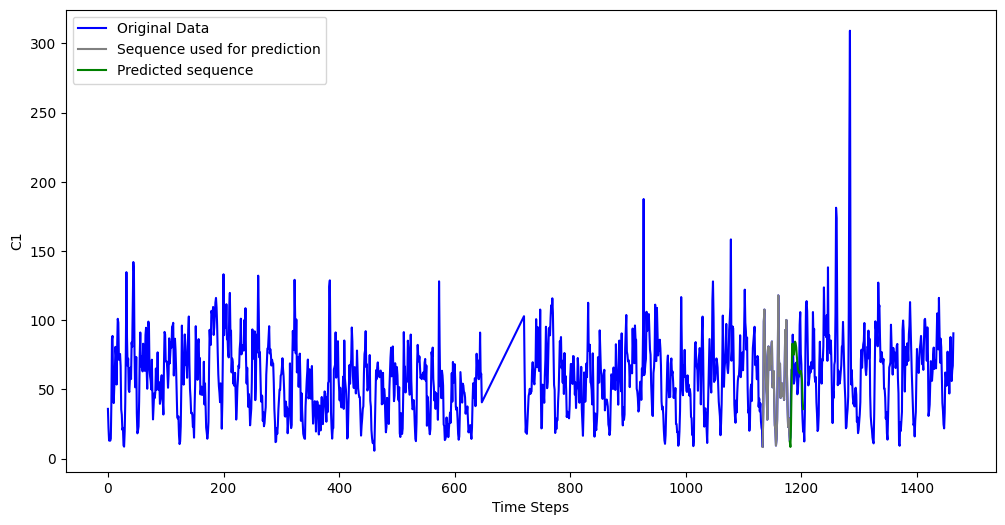

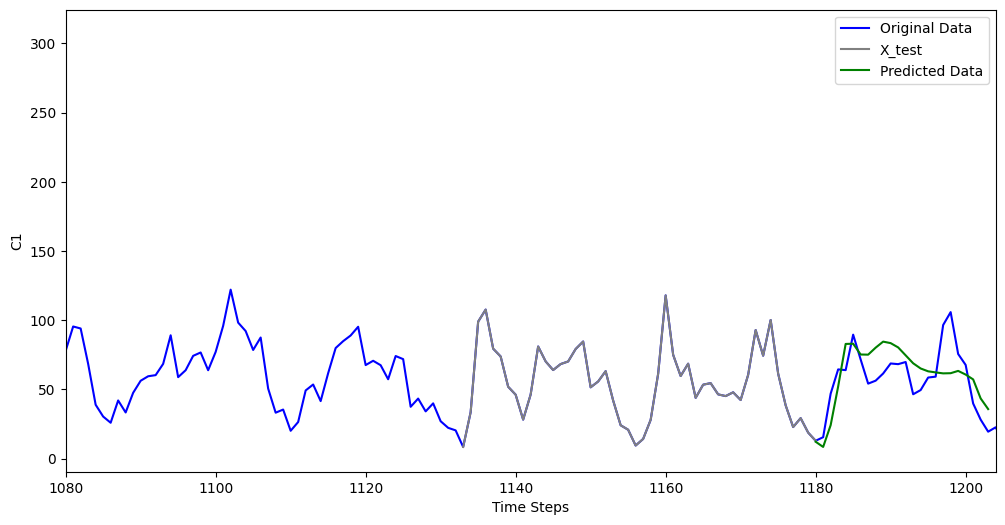

Epoch [100/2000], Loss: 0.009490185417234898
Epoch [200/2000], Loss: 0.008390515111386776
Epoch [300/2000], Loss: 0.005212984047830105
Epoch [400/2000], Loss: 0.004049003589898348
Epoch [500/2000], Loss: 0.003515543881803751
Epoch [600/2000], Loss: 0.00311270821839571
Epoch [700/2000], Loss: 0.0028515250887721777
Epoch [800/2000], Loss: 0.0025860394816845655
Epoch [900/2000], Loss: 0.0022808145731687546
Epoch [1000/2000], Loss: 0.002158928429707885
Epoch [1100/2000], Loss: 0.002111997688189149
Epoch [1200/2000], Loss: 0.0020174907986074686
Epoch [1300/2000], Loss: 0.001982502406463027
Epoch [1400/2000], Loss: 0.0020300548058003187
Epoch [1500/2000], Loss: 0.0019027474336326122
Epoch [1600/2000], Loss: 0.001889257226139307
Epoch [1700/2000], Loss: 0.001859214622527361
Epoch [1800/2000], Loss: 0.0018335237400606275
Epoch [1900/2000], Loss: 0.0018261736258864403
Epoch [2000/2000], Loss: 0.002354048890992999
Street: A5
Average Mean Absolute Error (MAE): 19.601970902834985
Average Root Mean

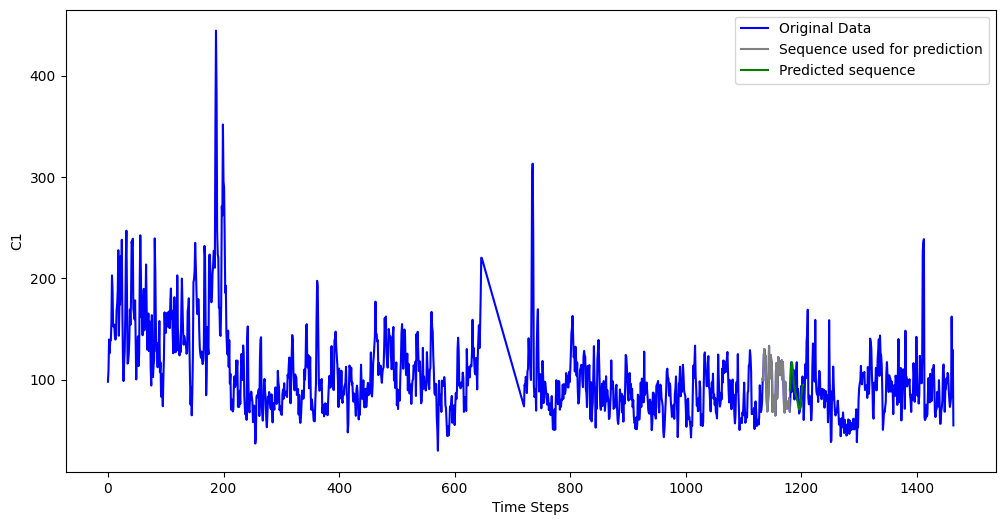

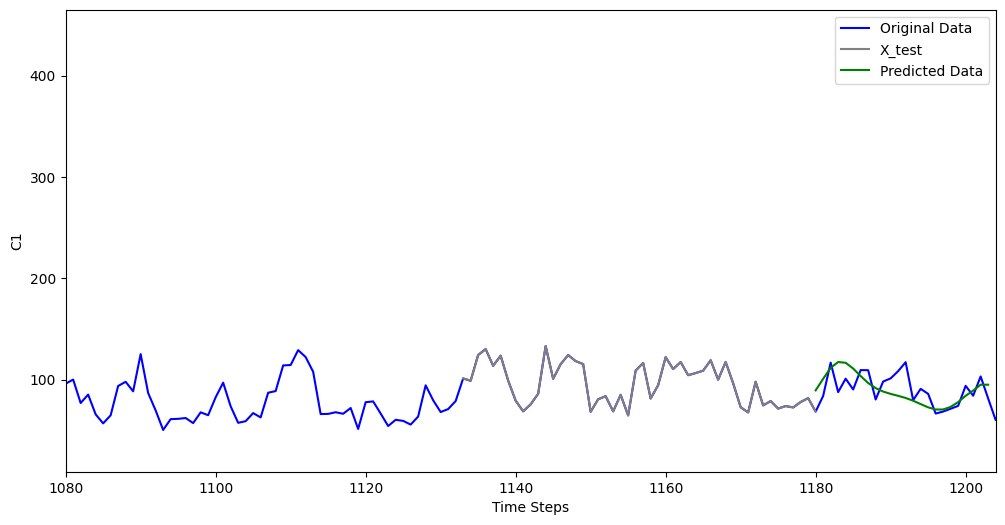

Epoch [100/2000], Loss: 0.01856604777276516
Epoch [200/2000], Loss: 0.012881152331829071
Epoch [300/2000], Loss: 0.008350104093551636
Epoch [400/2000], Loss: 0.0073806471191346645
Epoch [500/2000], Loss: 0.006823284551501274
Epoch [600/2000], Loss: 0.0064983307383954525
Epoch [700/2000], Loss: 0.006309216376394033
Epoch [800/2000], Loss: 0.006238847505301237
Epoch [900/2000], Loss: 0.006070052273571491
Epoch [1000/2000], Loss: 0.005964293610304594
Epoch [1100/2000], Loss: 0.005855640396475792
Epoch [1200/2000], Loss: 0.00575617840513587
Epoch [1300/2000], Loss: 0.005685044452548027
Epoch [1400/2000], Loss: 0.005581896286457777
Epoch [1500/2000], Loss: 0.00550022954121232
Epoch [1600/2000], Loss: 0.00542871281504631
Epoch [1700/2000], Loss: 0.005388034973293543
Epoch [1800/2000], Loss: 0.0052106198854744434
Epoch [1900/2000], Loss: 0.00512692192569375
Epoch [2000/2000], Loss: 0.005032261833548546
Street: N117
Average Mean Absolute Error (MAE): 21.081056409900935
Average Root Mean Square

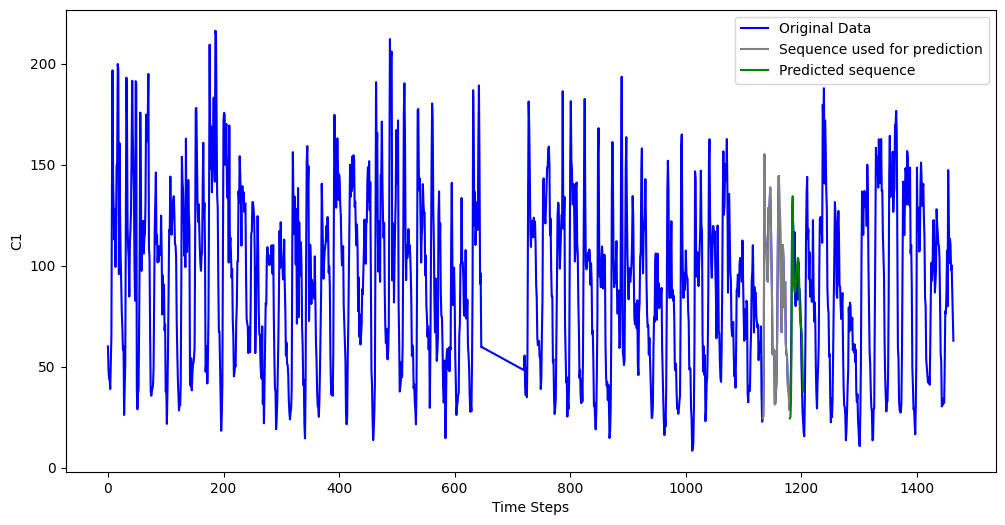

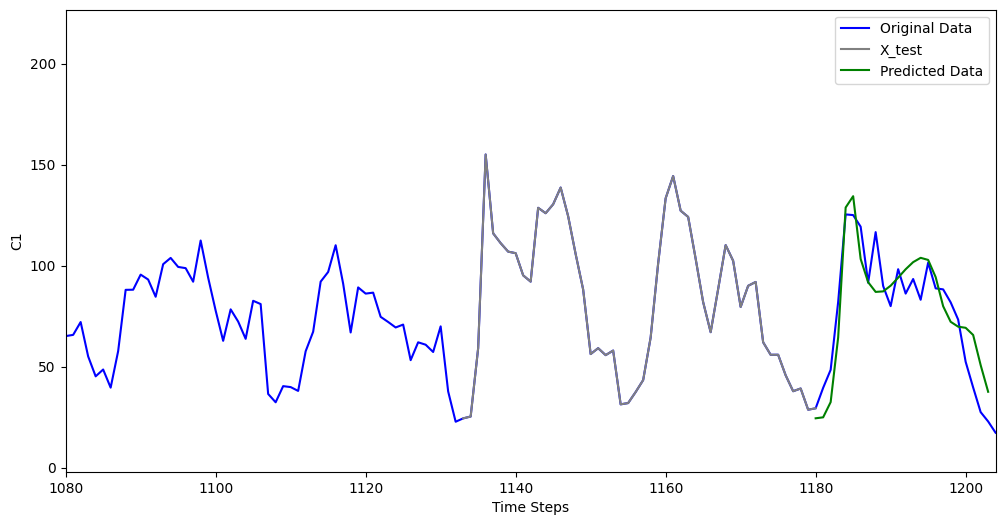

Epoch [100/2000], Loss: 0.01737384684383869
Epoch [200/2000], Loss: 0.015035695396363735
Epoch [300/2000], Loss: 0.012469458393752575
Epoch [400/2000], Loss: 0.007703536190092564
Epoch [500/2000], Loss: 0.006067046895623207
Epoch [600/2000], Loss: 0.005290523637086153


KeyboardInterrupt: 

In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define model parameters
INPUT_SIZE = 3
HIDDEN_SIZE = 30
OUTPUT_SIZE = 1  # Predicting one value (C1)
SEQUENCE_LENGTH = 72
NUM_EPOCHS = 2000
LEARNING_RATE = 0.001
TEST_SIZE = 0.2
RANDOM_STATE = 42
FUTURE = 24



class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


def create_sequences(data, day_of_week, hour, seq_length):
    sequences = []
    labels = []

    for i in range(len(data) - seq_length):
        seq = torch.cat([data[i:i+seq_length], day_of_week[i:i+seq_length], hour[i:i+seq_length]], dim=1)
        label = data[i+seq_length:i+seq_length+1]
        sequences.append(seq)
        labels.append(label)

    return torch.stack(sequences), torch.stack(labels)

def preprocess_data(df):

    # Resample the "C1" column for each hour and calculate the mean values
    df_hourly_mean = df["C1"].resample("H").mean().interpolate()    

    # Create a new DataFrame with the mean values, Grid_ID, and Datetime
    resampled_df = pd.DataFrame({
        "Grid_ID": df["Grid_ID"].resample("H").first(),
        "Datetime": df_hourly_mean.index,
        "C1": df_hourly_mean
    })

    # Add a new columns, might be useful later
    resampled_df["DayOfWeek"] = resampled_df["Datetime"].dt.dayofweek
    resampled_df["Hour"] = resampled_df["Datetime"].dt.hour
    day_of_week_values = resampled_df["DayOfWeek"].values
    day_of_week_tensor = torch.tensor(day_of_week_values, dtype=torch.float32).reshape(-1, 1)
    hour_values = resampled_df["Hour"].values
    hour_tensor = torch.tensor(hour_values, dtype=torch.float32).reshape(-1, 1)


    target_col = 'C1'
    target = resampled_df[target_col].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    target_scaled = scaler.fit_transform(target)
    target_tensor = torch.tensor(target_scaled, dtype=torch.float32)


    # Define sequence length and create sequences
    sequences, labels = create_sequences(target_tensor, day_of_week_tensor, hour_tensor, SEQUENCE_LENGTH)
    X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=False)
    return X_train, X_test, y_train, y_test, target, scaler

def train_model(X_train, y_train):
    model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    for epoch in range(NUM_EPOCHS):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)

        loss = criterion(outputs.squeeze(), y_train.squeeze()) 
        loss.backward()
        optimizer.step()

        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item()}')

    return model

def evaluate_model(model, X_test, y_test, scaler):
    # Your evaluation code here
    model.eval()
    num_test_sequences = len(X_test) - FUTURE
    test_sequences = X_test[:num_test_sequences, :, :]
    predicted_sequences = []
    with torch.no_grad():
        for test_seq in test_sequences:
            base_seq = test_seq.unsqueeze(0).clone()
            predicted_seq = []
            next_day = base_seq[:, -1:, 1]
            for i in range(FUTURE):
                pred = model(base_seq)
                predicted_seq.append(pred.item())

                next_hour = (base_seq[:, -1:, 2] + 1) % 24
                if(next_hour == 0):
                    next_day = (base_seq[:, -1:, 1] + 1) % 7
            
                next_value = torch.cat([pred.unsqueeze(2), next_day.unsqueeze(2), next_hour.unsqueeze(2)], dim=2)  # Include hour tensor
                base_seq = torch.cat([base_seq[:, 1:, :], next_value], dim=1)
            # Inverse transform the values
            predicted_seq = np.array(predicted_seq).reshape(-1, 1)
            predicted_seq = scaler.inverse_transform(predicted_seq)
            predicted_sequences.append(predicted_seq)


    y_test = scaler.inverse_transform(y_test.squeeze().reshape(-1, 1))
    mae_list = []
    rmse_list = []

    for i in range(num_test_sequences):
        y_t = y_test[i:i+FUTURE]
        predicted_seq = predicted_sequences[i]
        mae = mean_absolute_error(y_t, predicted_seq)
        rmse = np.sqrt(mean_squared_error(y_t, predicted_seq))

        mae_list.append(mae)
        rmse_list.append(rmse)

    average_mae = np.mean(mae_list)
    average_rmse = np.mean(rmse_list)

    
    return predicted_sequences, test_sequences, average_mae, average_rmse

def plot_results(target, y_test, predicted_sequences, seq_used_pred):
    test_start = len(target) - len(y_test)

    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(target)), target, label='Original Data', color='blue')
    plt.plot(np.arange(test_start - len(seq_used_pred), test_start) + 1,  np.array(seq_used_pred).reshape(-1, 1), label='Sequence used for prediction', color='gray')
    plt.plot(np.arange(test_start, test_start + FUTURE), predicted_sequences[0], label='Predicted sequence', color='green')

    plt.xlabel('Time Steps')
    plt.ylabel("C1")
    plt.legend()
    plt.show()

def plot_zoomed(target, y_test, predicted_sequences, seq_used_pred, zoom_range=100):
    test_start = len(target) - len(y_test)

    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(target)), target, label='Original Data', color='blue')
    plt.plot(np.arange(test_start - len(seq_used_pred), test_start) + 1,  np.array(seq_used_pred).reshape(-1, 1), label='Sequence used for prediction', color='gray')
    plt.plot(np.arange(test_start, test_start + FUTURE), predicted_sequences[0], label='Predicted Data', color='green')

    # Zoom in on a smaller period of time
    plt.xlim(test_start - zoom_range, test_start + FUTURE)

    plt.xlabel('Time Steps')
    plt.ylabel("C1")
    plt.legend()
    plt.show()

def main():
    # df = pd.read_csv("data/reduced/June2022_reduced.csv")
    for ax, street_name in zip(axes.flatten(), street_names):
        street_df = entrance_roads_df[entrance_roads_df['street_name'] == street_name].copy()
        street_df.set_index('Datetime', inplace=True)
        X_train, X_test, y_train, y_test, target, scaler = preprocess_data(street_df)
        model = train_model(X_train, y_train)
        predicted_sequences, test_sequences, average_mae, average_rmse = evaluate_model(model, X_test, y_test, scaler)
        print(f"Street: {street_name}")
        print(f"Average Mean Absolute Error (MAE): {average_mae}")
        print(f"Average Root Mean Squared Error (RMSE): {average_rmse}")
        seq_used_pred = scaler.inverse_transform(test_sequences[1, :,0].squeeze().reshape(-1, 1).clone())
        plot_results(target, y_test, predicted_sequences, seq_used_pred)
        plot_zoomed(target, y_test, predicted_sequences, seq_used_pred)

if __name__ == "__main__":
    main()

### Experimenting with LSTM model

Several experiments were conducted to evaluate the performance of an LSTM model in predicting time series data. The LSTM model was employed to predict consecutive values of the C1 parameter, representing the number of distinct terminals in the grid. To clean the dataset, irrelevant columns were removed, and a specific grid (number 16) was chosen for experimentation. The C1 parameter was resampled to reflect the mean traffic in each hour and interpolated to address missing values.

Data transformation involved organizing it into sequences and labels suitable for LSTM training. Each sequence comprised 80 values, predicting one value. Subsequently, all sequences were divided into training and testing sets. The model underwent training and evaluation, wherein 100 consecutive values were predicted from a sequence in the test set to assess model performance.

The results are depicted in a line plot, illustrating the predicted values, original data, and the sequence used for prediction. Plot presents period of one month, with time step equal one hour. This plot aids in gauging the accuracy of LSTM predictions. Observably, there is room for potential enhancement, suggesting avenues for improvement. For instance, incorporating additional parameters for prediction, such as the day of the week or hour, could refine the model's performance. Tweaking the hyperparameters and trying with more data might make the results better. We'll give it a shot in the next steps. 


